In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_2780\2216647736.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

# remove rows with outliers
data = data[data["total sulfur dioxide"] < 200]

# z score all variables except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

In [6]:
def createAdataset(qualThreshold):

    # create a new column for binarized (boolean) quality
    data["boolQuality"] = 0

    tmp = (data["quality"]>qualThreshold).astype(int)
    data["boolQuality"] = tmp

    # convert from pandas dataframe to tensor
    dataT = torch.tensor(data[cols2zscore].values).float()
    labels = torch.tensor(data["boolQuality"].values).float()
    # we'll actually need the labels to be a tensor
    labels = labels[:, None]
    
    train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .1)
    
    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)
    
    # finally, translate into dataloader objects
    batchsize = 8
    train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
    test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

    return train_loader, test_loader

In [20]:
# test the dataset and the number of samples

# note that the data are roughly balanced with thresh = 5, not 4 or 6
train_loader, test_loader = createAdataset(5)

# get the number of high/low quality wines
qualityRatings = train_loader.dataset.tensors[1].detach()
print("%s low-rated wines" %torch.sum(qualityRatings == 0).item())
print("%s high-rated wines" %torch.sum(qualityRatings == 1).item())

669 low-rated wines
768 high-rated wines


In [21]:
# create a class for this model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11, 16)
    
        # hidden layer
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)
    
        # output layer
        self.output = nn.Linear(32, 1)

    # forward pass
    def forward(self, x):
        x = F.leaky_relu(self.input(x))
        x = F.leaky_relu(self.fc1(x)) # fc = fully connected
        x = F.leaky_relu(self.fc2(x))
        return self.output(x) # pytorch will automatically assign sigmoid function to the output layer inside loss function

In [22]:
 # train the model

# training parameter
numepochs = 500

def trainTheModel():
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)

    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(winenet.parameters(), lr = .001)
    
    # train the model
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates auto grad
            yHat = winenet(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
        
    # function output
    return trainAcc, testAcc, losses

In [23]:
# create the data
train_loader, test_loader = createAdataset(5)

# create a model and train it
winenet = ANNwine()
trainAcc, testAcc, losses = trainTheModel()

# compute accuracy per quality type
X, y = next(iter(test_loader))
yHat = winenet(X)
itemAccuracy = ((yHat > 0) == y).float()

perQualAcc = [100 * torch.mean(itemAccuracy[y == 0]),
             100 * torch.mean(itemAccuracy[y == 1])]
perQualAcc

[tensor(80.), tensor(77.5000)]

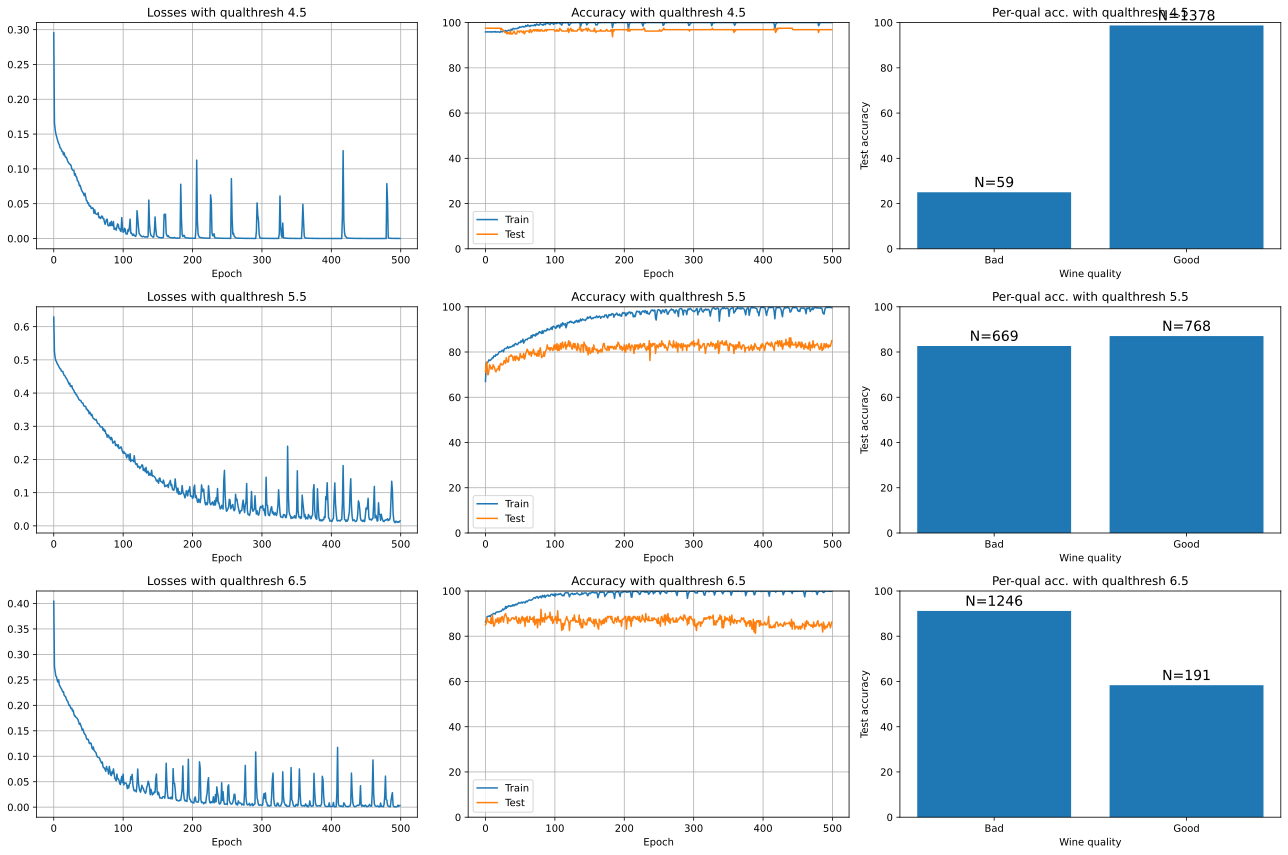

In [26]:
# set up the figure
fig, ax = plt.subplots(3, 3, figsize = (18, 12))

# the quality thresholds
qualityThresholds = [4, 5, 6]

# loop over quality thresholds
for quali in range(len(qualityThresholds)):

    # create the data and model and train it
    train_loader, test_loader = createAdataset(qualityThresholds[quali])
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainTheModel()

    # compute accuracy per quality type
    X, y = next(iter(test_loader))
    itemAccuracy = ((winenet(X) > 0) == y).float()
    perQualAcc = [100 * torch.mean(itemAccuracy[y == 0]),
             100 * torch.mean(itemAccuracy[y == 1])]

    # plot losses
    ax[quali,0].plot(losses)
    ax[quali,0].set_title('Losses with qualthresh ' + str(qualityThresholds[quali]+.5))
    ax[quali,0].set_xlabel('Epoch')
    ax[quali,0].grid()
    
    # plot overall accuracy
    ax[quali,1].plot(trainAcc,label='Train')
    ax[quali,1].plot(testAcc,label='Test')
    ax[quali,1].set_title('Accuracy with qualthresh ' + str(qualityThresholds[quali]+.5))
    ax[quali,1].legend()
    ax[quali,1].set_xlabel('Epoch')
    ax[quali,1].set_ylim([0,100])
    ax[quali,1].grid()
    
    # plot the per-quality accuracy
    bh = ax[quali,2].bar(['Bad','Good'],perQualAcc)
    ax[quali,2].set_ylim([0,100])
    ax[quali,2].set_xlabel('Wine quality')
    ax[quali,2].set_ylabel('Test accuracy')
    ax[quali,2].set_title('Per-qual acc. with qualthresh ' + str(qualityThresholds[quali]+.5))
    
    # print the counts on top of each bar
    for i,r in enumerate(bh):
        N = torch.sum(train_loader.dataset.tensors[1]==i).item()
        ax[quali,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
                  'N=%s'%N, ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()